<a href="https://colab.research.google.com/github/qntkhvn/cmsac_rrc/blob/main/2022/aging_cmsac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Aging Curve Estimation Using Multiple Imputation**
#### ***Submitted to #CMSAC22 Reproducible Research Competition***
<br>

---



##### **Data prep**

In [ ]:
install.packages(c("tidyverse",
                   "Lahman",
                   "lme4",
                   "mice",
                   "mosaic"))

In [2]:
library(tidyverse)
library(Lahman)

# join Batting and People tables
# use OPS as performance measure
# scale/transform OPS
# keep players with at least 100 plate appearances
# age correction based on birth month
mlb_sim <- Batting |> 
  group_by(playerID, yearID) |> 
  summarise(across(G:GIDP, sum)) |> 
  battingStats() |> 
  left_join(People, by = "playerID") |> 
  filter(PA >= 100) |> 
  mutate(age = ifelse(birthMonth >= 7, yearID - birthYear - 1, yearID - birthYear),
         ops_trans = asin(sqrt(OPS / max(OPS))))

# get highest OPS value
max_ops <- max(mlb_sim$OPS)

`summarise()` has grouped output by 'playerID'. You can override using the
`.groups` argument.


##### **Mixed-effects model**

In [3]:
library(lme4)
set.seed(100)

# more details in paper section 4.1 
mlb_fit <- lmer(ops_trans ~ poly(age, 3, raw = TRUE) + (1 | playerID),
               data = mlb_sim)

# variance-covariance matrix
var_cor <- mlb_fit |> 
  VarCorr() |> 
  as_tibble()

var_cor

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Warning message:
“Some predictor variables are on very different scales: consider rescaling”


grp,var1,var2,vcov,sdcor
<chr>,<chr>,<chr>,<dbl>,<dbl>
playerID,(Intercept),NA,0.005049078,0.07105686
Residual,NA,NA,0.003796987,0.06161970


##### **Generate fictional player careers**

In [4]:
age_sim <- 21:39
sim_career <- function() {
  # baseline
  pred <- predict(mlb_fit, tibble(age = age_sim), re.form = NA)
  # deviation from baseline
  shift <- rnorm(1, 0, var_cor$sdcor[1])
  # variability across seasons
  eps <- rnorm(length(age_sim), 0, var_cor$sdcor[2])
  return(pred + shift + eps)
}

sim_list <- c()
nsim <- 1000
for (i in 1:nsim) {
  sim_list[[i]] <- tibble(player = i,
                          ops_trans = sim_career(),
                          age = age_sim)
}

sim_df <- sim_list |> 
  bind_rows() |> 
  mutate(ops = max_ops * sin(ops_trans) ^ 2)

##### **Create dropout mechanisms**

In [5]:
# at age 30, 25% randomly retire
# aging curve remains the same
players <- unique(sim_df$player)
rand_players <- sample(players, length(players) / 4)

retire_30 <- sim_df |> 
  filter(player %in% rand_players, age >= 30)

out_random_30 <- sim_df |> 
  anti_join(retire_30)

Joining, by = c("player", "ops_trans", "age", "ops")


In [6]:
# drop 1st half of career 
# when average from start to 25 is below 0.55
ops_avg_start <- sim_df |> 
  filter(age <= 25) |> 
  group_by(player) |> 
  summarise(avg = mean(ops)) |> 
  filter(avg < 0.55)

out_avg_start <- sim_df |> 
  mutate(ops = ifelse(player %in% ops_avg_start$player & age > 25, NA, ops),
         ops_trans = ifelse(is.na(ops), NA, ops_trans)) 

In [7]:
# drop if any 4-year avg is below 0.55
get_drop_4yr <- sim_df |> 
  group_by(player) |> 
  filter((ops + lag(ops) + lag(ops, 2) + lag(ops, 3)) / 4 < 0.55) |> 
  slice_min(age) |> 
  select(player, drop_age = age)

out_4yr_avg <- sim_df |> 
  left_join(get_drop_4yr) |> 
  mutate(drop_age = ifelse(is.na(drop_age), 40, drop_age),
         ops = ifelse(age > drop_age, NA, ops),
         ops_trans = ifelse(is.na(ops), NA, ops_trans)) |>
  select(-drop_age)

Joining, by = "player"


##### **Compare dropout mechanisms**

`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.
`geom_smooth()` using formula 'y ~ x'



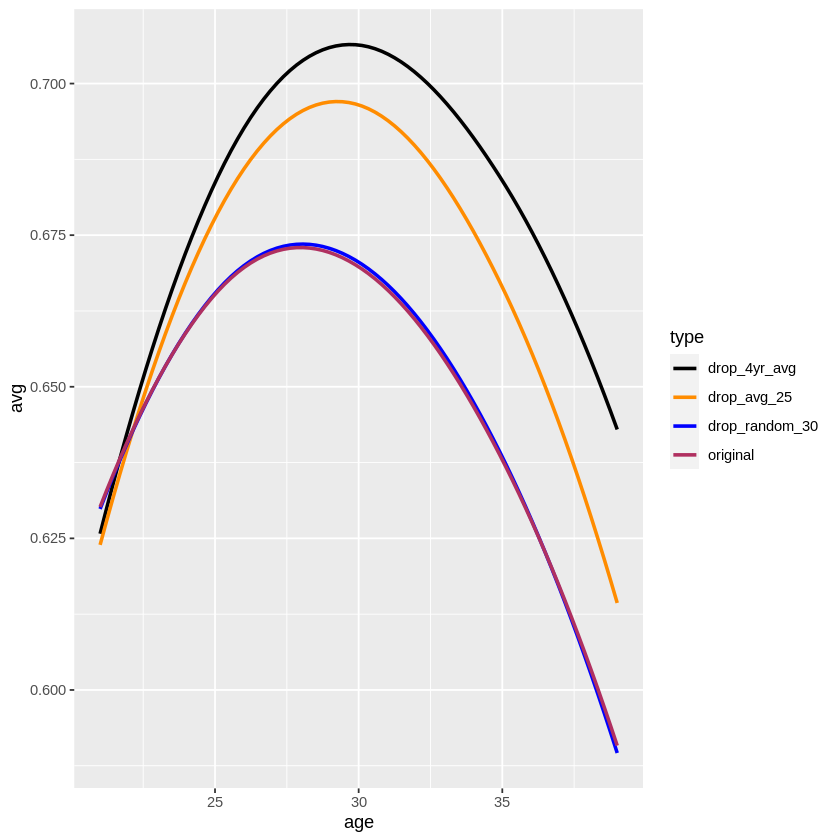

In [8]:
mutate(sim_df, type = "original") |>
  bind_rows(mutate(out_random_30, type = "drop_random_30")) |>
  bind_rows(mutate(out_avg_start, type = "drop_avg_25")) |>
  bind_rows(mutate(out_4yr_avg, type = "drop_4yr_avg")) |> 
  group_by(type, age) |> 
  summarise(avg = mean(ops, na.rm = TRUE)) |> 
  ggplot(aes(x = age, y = avg, color = type)) +
  geom_smooth(method = "loess", se = FALSE, size = 1, span = 1.5) +
  scale_color_manual(values = c("black", "darkorange", "blue", "maroon"))

In [9]:
# mean absolute error
mae <- function(y, pred) {
    return(mean(abs(y - pred)))
}

In [10]:
# compare dropout and true curves using mae
library(mosaic)
mae(mean(ops ~ age, data = sim_df), mean(ops ~ age, data = out_random_30))
mae(mean(ops ~ age, data = sim_df), mean(ops ~ age, na.rm = TRUE, data = out_avg_start))
mae(mean(ops ~ age, data = sim_df), mean(ops ~ age, na.rm = TRUE, data = out_4yr_avg))

Registered S3 method overwritten by 'mosaic':
  method                           from   
  fortify.SpatialPolygonsDataFrame ggplot2


The 'mosaic' package masks several functions from core packages in order to add 
additional features.  The original behavior of these functions should not be affected by this.


Attaching package: ‘mosaic’


The following object is masked from ‘package:lme4’:

    factorize


The following object is masked from ‘package:Matrix’:

    mean


The following objects are masked from ‘package:dplyr’:

    count, do, tally


The following object is masked from ‘package:purrr’:

    cross


The following object is masked from ‘package:ggplot2’:

    stat


The following objects are masked from ‘package:stats’:

    binom.test, cor, cor.test, cov, fivenum, IQR, median, prop.test,
    quantile, sd, t.test, var


The following objects are masked from ‘package:base’:

    max, mean, min, prod, range, sample, sum




[1] 0.0007419965

[1] 0.01936545

[1] 0.03143227

##### **Multiple imputation: Helper functions**

In [11]:
# helper function: imputation with age as the only predictor
library(mice)
set.seed(100)

imp_age_only <- function(df, nimp = 5, niter = 30) {
  
  imp_df <- df |> 
    dplyr::select(player, age, ops_trans)
  
  # initial imputation object
  ini <- imp_df |> 
    mice::mice(maxit = 0)
  
  # get predictor matrix
  pred_mat <- ini |> 
    purrr::pluck("predictorMatrix")
  
  # specify effects
  pred_mat["ops_trans", ] <- c(-2, 2, 0)
  
  # default: 5 imputations, 30 iterations for each
  # linear two-level model with heterogeneous within-class variance
  imp <- imp_df |> 
    mice::mice(predictorMatrix = pred_mat, 
               method = "2l.norm",
               m = nimp,
               maxit = niter,
               print = FALSE)
  
  return(imp)
}


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind




In [12]:
# helper function: get completed datasets after imputing
imp_comp <- function(imp) {
  comp <- imp |>
    mice::complete("long", include = TRUE) |>
    dplyr::mutate(ops = max_ops * (sin(ops_trans)) ^ 2)
  return(comp)
}

In [13]:
# helper function: combine imputation results
imp_comb <- function(imp, alpha = 0.05) {
  comb <- imp |>
    mice::complete("long") |> 
    dplyr::group_by(.imp, age) |>
    dplyr::summarize(est = mean(ops_trans),
                     v = var(ops_trans)) |> 
    dplyr::ungroup() |> 
    dplyr::group_by(age) |> 
    dplyr::summarize(avg = mean(est),
                     vw = sum(v) / imp$m, # Within imputation variance
                     vb = sum((est - avg) ^ 2) / (imp$m - 1), # Between imputation variance
                     vt = vw + vb + vb / imp$m, # total variability
                     se_pooled = sqrt(vt), # pooled se
                     lambda = (vb + vb / imp$m) / vt,
                     riv = (vb + vb / imp$m) / vw,
                     df = (imp$m - 1) / (lambda ^ 2), 
                     upper = avg + qt(1 - alpha / 2, df) * se_pooled,
                     lower = avg - qt(1 - alpha / 2, df) * se_pooled) |> 
    dplyr::transmute(age,
                     ops = max_ops * (sin(avg)) ^ 2,
                     ops_upper = max_ops * (sin(upper)) ^ 2,
                     ops_lower = max_ops * (sin(lower)) ^ 2)
  return(comb)
}

##### **Multiple imputation: Analysis**

In [14]:
# illustrate imputation for dropout case of low OPS average at start of career (age 21-25)
imp_avg_start <- out_avg_start |>
  imp_age_only()

bind_vars <- c("player", "age", "ops", "curve")
sim_df_bind <- sim_df |> 
  mutate(curve = "Original") |> 
  select(all_of(bind_vars))

comp_avg_start <- imp_avg_start |> 
  imp_comp() |> 
  mutate(curve = paste("Imputation", .imp),
         curve = str_replace(curve, "Imputation 0", "Missing")) |> 
  select(all_of(bind_vars)) |> 
  bind_rows(sim_df_bind)

comb_avg_start <- imp_avg_start |> 
  imp_comb() |> 
  mutate(curve = "Combined")

`summarise()` has grouped output by '.imp'. You can override using the
`.groups` argument.


In [15]:
# mae between fully observed and imputed data
mae(mean(ops ~ age, data = sim_df), mean(ops ~ age, data = comb_avg_start))

[1] 0.003890988

`summarise()` has grouped output by 'curve'. You can override using the
`.groups` argument.
`geom_smooth()` using formula 'y ~ x'



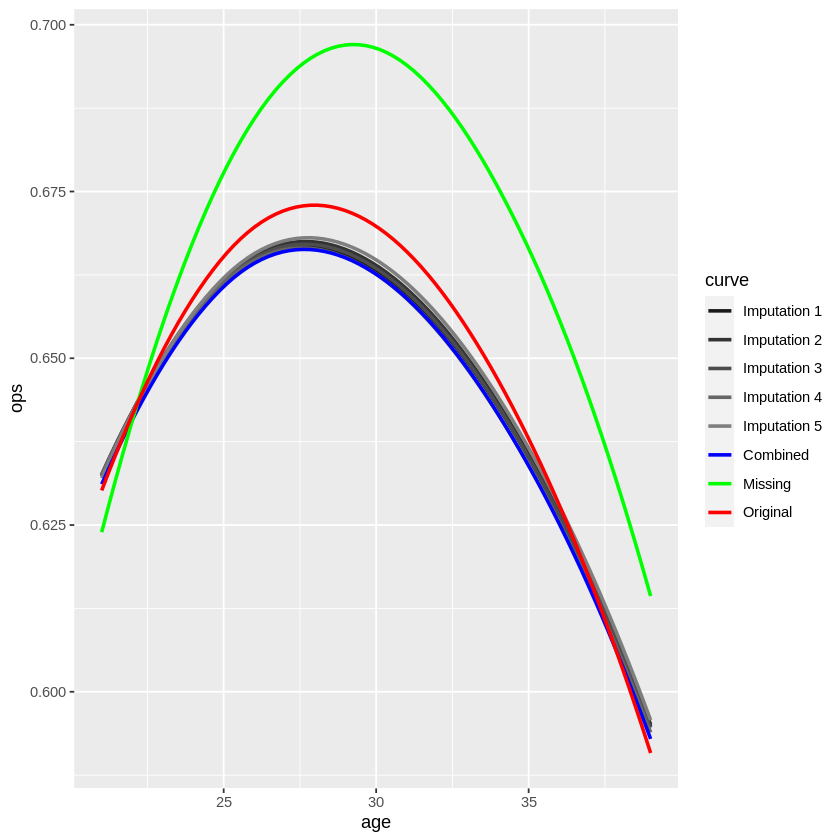

In [16]:
# original vs missing vs imputed curves
comp_avg_start |> 
  group_by(curve, age) |>
  summarise(ops = mean(ops, na.rm = TRUE)) |> 
  bind_rows(comb_avg_start) |> 
  mutate(curve = factor(curve, levels = c(str_c("Imputation ", 1:5), "Combined", "Missing", "Original"))) |> 
  ggplot(aes(x = age, y = ops, color = curve)) +
  geom_smooth(method = "loess", span = 1.5, se = FALSE) +
  scale_color_manual(values = c(str_c("gray", seq(10, 50, 10)), "blue", "green", "red"))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



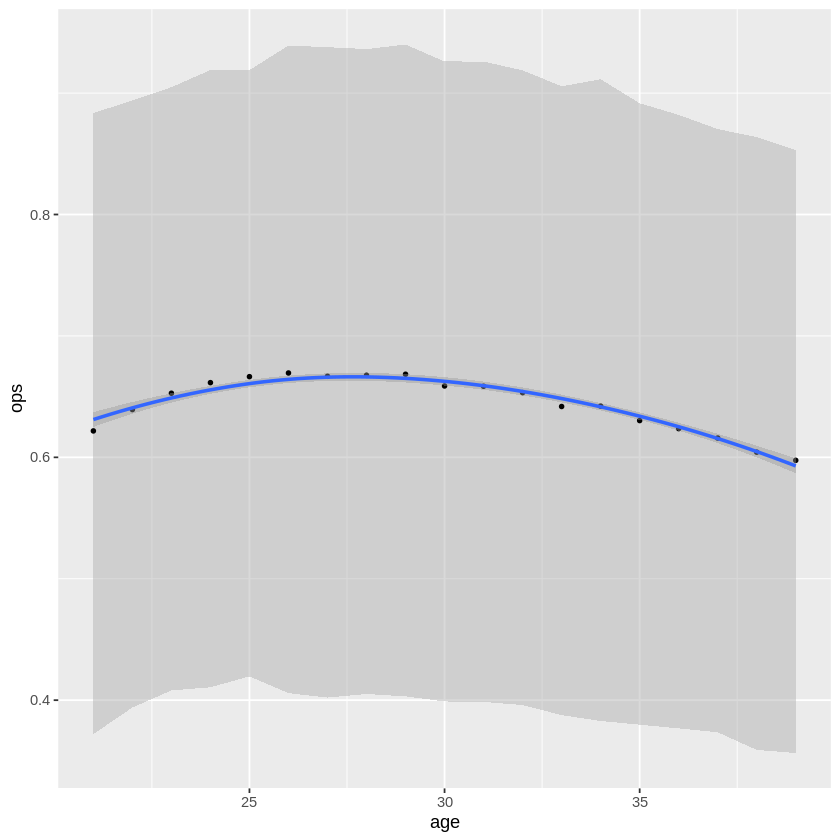

In [17]:
# combined curve with 95% CI
comb_avg_start |> 
  ggplot(aes(age, ops)) +
  geom_ribbon(aes(ymin = ops_lower, ymax = ops_upper), fill = "grey70", alpha = 0.5) +
  geom_point(size = 0.9) +
  geom_smooth(span = 1.5)

##### **Multiple imputation: Diagnostics**

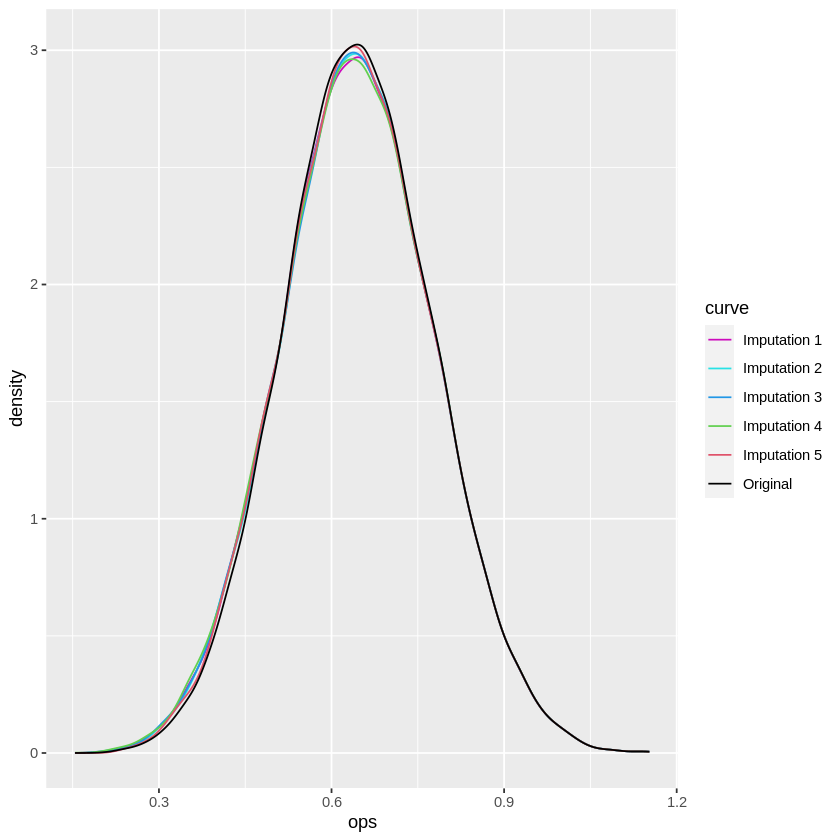

In [18]:
# check for distribution discrepancy
# compare densities of imputed and observed data
comp_avg_start |> 
  filter(curve != "Missing") |> 
  ggplot(aes(ops, color = curve)) +
  stat_density(geom = "line", position = "identity", size = 0.5) +
  scale_color_manual(values = c(palette()[6:2], "black")) 

In [19]:
# check for convergence of imputation
# helper function to get data for trace plot
imp_trace <- function(imp) {
  mn <- imp$chainMean[3, , ] |> 
    dplyr::as_tibble() |> 
    dplyr::mutate(iter = row_number()) |>
    tidyr::pivot_longer(!iter,
                        names_to = "chain",
                        names_prefix = "Chain ",
                        values_to = "mean")
  std <- imp$chainVar[3, , ] |> 
    dplyr::as_tibble() |> 
    dplyr::mutate(iter = row_number()) |>
    tidyr::pivot_longer(!iter,
                        names_to = "chain",
                        names_prefix = "Chain ",
                        values_to = "sd",
                        values_transform = list(sd = sqrt))
  conv <- mn |> 
    dplyr::full_join(std) |> 
    tidyr::pivot_longer(mean:sd)
  return(conv)
}

Joining, by = c("iter", "chain")


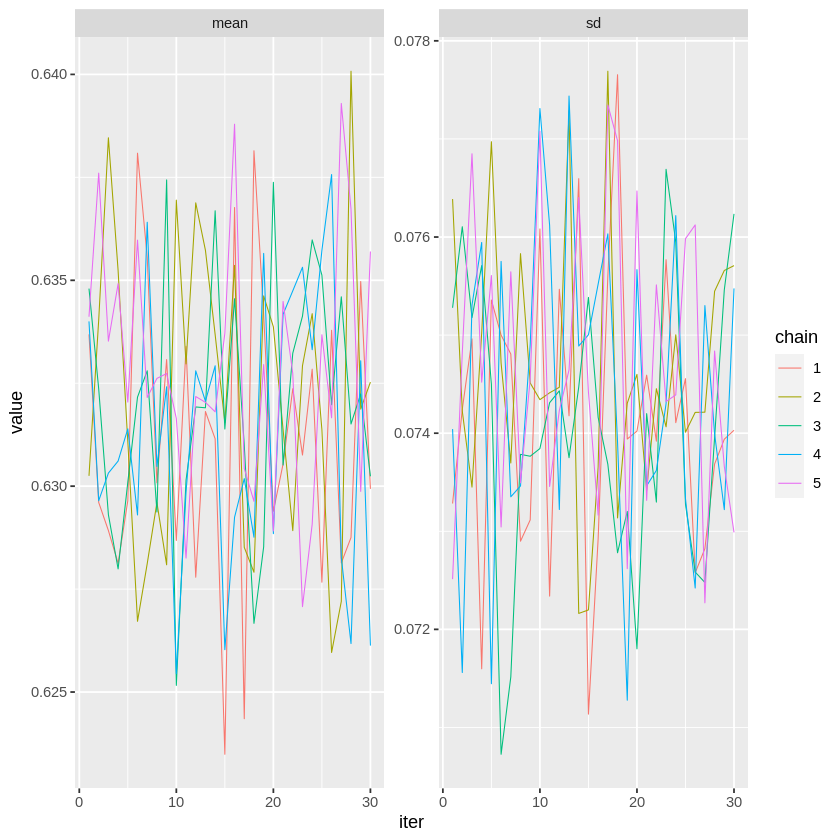

In [20]:
# trace plot for mean and sd
imp_avg_start |> 
  imp_trace() |> 
  ggplot(aes(iter, value, color = chain)) +
  geom_line(size = 0.3) +
  facet_wrap(~ name, scales = "free")

##### **Application to real data**

In [21]:
# similar prep to simulation
# consider players with debut year no sooner than 1985
mlb_real <- Batting |> 
  group_by(playerID, yearID) |> 
  summarise(across(G:GIDP, sum)) |> 
  battingStats() |> 
  left_join(People, by = "playerID") |> 
  mutate(age = ifelse(birthMonth >= 7, yearID - birthYear - 1, yearID - birthYear))

age_range <- 21:39
mlb_real_imp <- mlb_real |> 
  filter(PA >= 100, age %in% age_range, str_sub(debut, 1, 4) >= 1985) |> 
  mutate(ops_trans = asin(sqrt(OPS / max(OPS))),
         pnum = as.integer(as.factor(playerID)))


# create data with observed and missing seasons for players
players <- unique(mlb_real_imp$playerID)
players_age <- tibble(playerID = rep(players, each = length(age_range))) |> 
  group_by(playerID) |> 
  mutate(age = age_range) |> 
  ungroup()

all_players <- players_age |> 
  left_join(mlb_real_imp) |> 
  mutate(player = as.integer(factor(playerID)))

# imputation
set.seed(100)
imp_mlb_age_only <- all_players |> 
  imp_age_only()

`summarise()` has grouped output by 'playerID'. You can override using the
`.groups` argument.
Joining, by = c("playerID", "age")


`summarise()` has grouped output by 'type'. You can override using the
`.groups` argument.
`summarise()` has grouped output by '.imp'. You can override using the
`.groups` argument.
`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



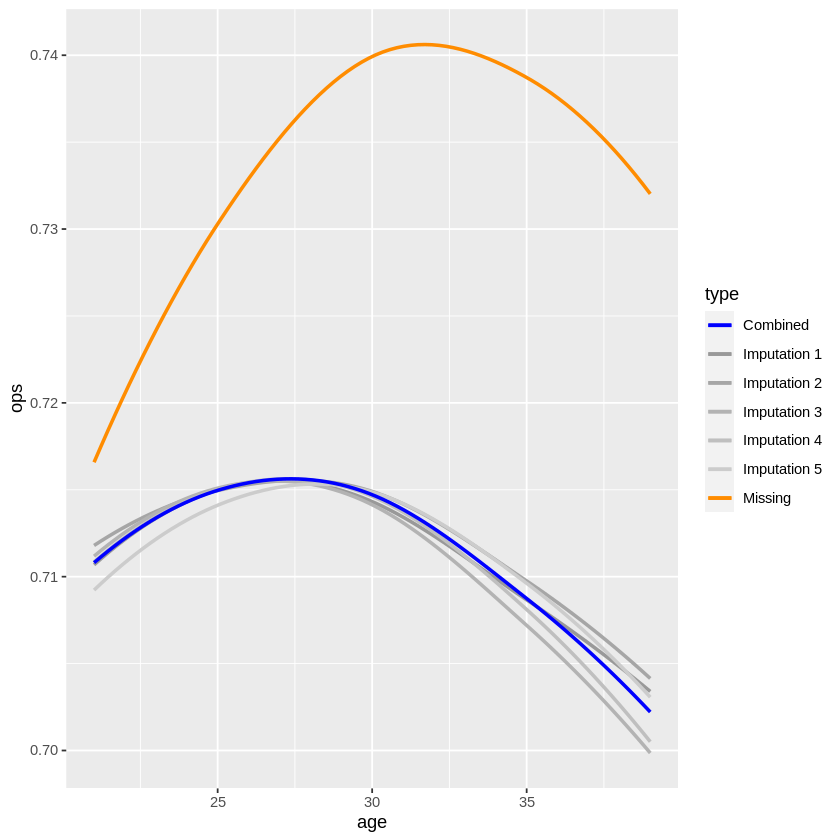

In [22]:
# compare imputed and non-imputed curves
imp_mlb_age_only |> 
  imp_comp() |> 
  mutate(type = paste("Imputation", .imp),
         type = str_replace(type, "Imputation 0", "Missing")) |> 
  select(.id, age, ops, type) |> 
  group_by(type, age) |>
  summarise(ops = mean(ops, na.rm = TRUE)) |> 
  ggplot(aes(age, ops, color = type)) +
  geom_smooth(method = "loess", span = 1.5, se = FALSE) +
  geom_smooth(aes(age, ops), se = FALSE, method = "loess", span = 1.5,
              data = mutate(imp_comb(imp_mlb_age_only), type = "Combined")) +
  scale_color_manual(values = c("blue", str_c("gray", seq(60, 80, 5)), "darkorange"))